In [46]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gzip
import os
import requests
from anndata import AnnData
import scanpy as sc
from scipy import stats
import copy
import pickle
seed=314159
device='cuda'
from GPerturb_model_1 import *

This notebook only contains codes for reproducing figures. Details regrading computation of relavent quantities can be found on Github

# Fig 2

166.38859605789185


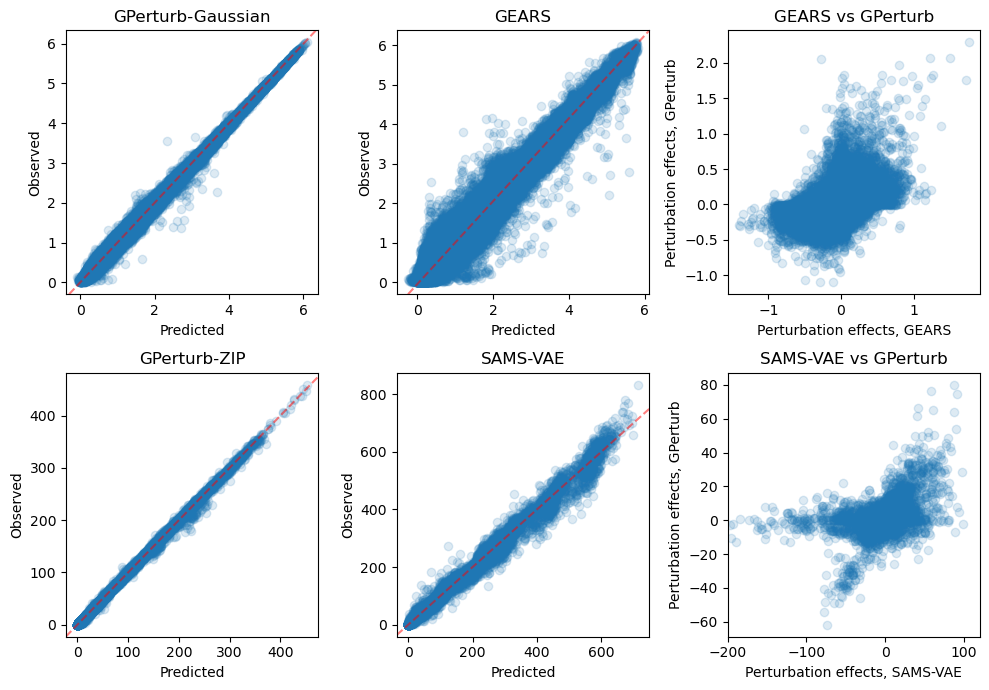

In [18]:
start=time.time()
avg_pred_GPerturb = np.loadtxt('./GPerturb_vis_data/rep_avg_pred_GPerturb_Gaussian.csv')
avg_obs_GPerturb = np.loadtxt( './GPerturb_vis_data/rep_avg_obs_GPerturb_Gaussian.csv')

# Comparing GPerturb vs GEARS on continuous data
pert_response = pd.read_csv('./GPerturb_vis_data/rep_GEARS_pred.csv', index_col=0).to_numpy()
obs_mean_rep = np.load('./GPerturb_vis_data/avg_rep_GEARS.npy')
np.corrcoef(pert_response.ravel(), obs_mean_rep.ravel())

fig, axes = plt.subplots(2, 3)
axes[0, 0].scatter(avg_pred_GPerturb[avg_obs_GPerturb != 0], avg_obs_GPerturb[avg_obs_GPerturb != 0], alpha=0.15)
axes[0, 0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Observed')
axes[0, 0].set_title('GPerturb-Gaussian')

axes[0, 1].scatter(pert_response[obs_mean_rep != 0], obs_mean_rep[obs_mean_rep != 0], alpha=0.15)
axes[0, 1].axline((1, 1), slope=1.05, c='r', alpha=0.5, linestyle='--')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Observed')
axes[0, 1].set_title('GEARS')



a = pd.read_csv('./GPerturb_vis_data/rep_GEARS_pred_alone.csv', index_col=0)
b = pd.read_csv('./GPerturb_vis_data/rep_avg_pred_Gaussian_alone.csv', index_col=0)

# align the genes_id and perturbation_ids
a_pert = list(a.index)
b_pert = list(b.index)
inter_b = [_ in a_pert for _ in b_pert]
inter_a = [_ in b_pert for _ in a_pert]
a = a[inter_a]
b = b[inter_b]
a_pert = list(a.columns)
b_pert = list(b.columns)
inter_b = [_ in a_pert for _ in b_pert]
inter_a = [_ in b_pert for _ in a_pert]
a = a.iloc[:, inter_a]
b = b.iloc[:, inter_b]
a = a.sort_index()
b = b.sort_index()

axes[0, 2].scatter(a.to_numpy().ravel(), b.to_numpy().ravel(), alpha=0.15)
axes[0, 2].set_xlabel('Perturbation effects, GEARS')
axes[0, 2].set_ylabel('Perturbation effects, GPerturb')
axes[0, 2].set_title('GEARS vs GPerturb')


# Comparing GPerturb vs SAMS-VAE on count data
avg_pred_GPerturb = np.loadtxt('./GPerturb_vis_data/rep_avg_pred_GPerturb_zip.csv')
avg_obs_GPerturb = np.loadtxt('./GPerturb_vis_data/rep_avg_obs_GPerturb_zip.csv')
avg_pred_SAMS = np.loadtxt('./GPerturb_vis_data/sams_vae_avg_pred.csv')
avg_obs_SAMS = np.loadtxt('./GPerturb_vis_data/sams_vae_avg_obs.csv')

axes[1, 0].scatter(avg_pred_GPerturb[avg_obs_GPerturb != 0], avg_obs_GPerturb[avg_obs_GPerturb != 0], alpha=0.15)
axes[1, 0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Observed')
axes[1, 0].set_title('GPerturb-ZIP')

axes[1, 1].scatter(avg_pred_SAMS[avg_obs_SAMS != 0], avg_obs_SAMS[avg_obs_SAMS != 0], alpha=0.15)
axes[1, 1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Observed')
axes[1, 1].set_title('SAMS-VAE')


a = pd.read_csv('./GPerturb_vis_data/rep_SAMS_VAE_treatment_effects.csv', index_col=0)
b = pd.read_csv('./GPerturb_vis_data/rep_GPerturb_ZIP_treatment.csv', index_col=0)
# align the genes and perturbations
a_pert = list(a.index)
b_pert = list(b.index)
inter_b = [_ in a_pert for _ in b_pert]
inter_a = [_ in b_pert for _ in a_pert]
a = a[inter_a]
b = b[inter_b]
a_pert = list(a.columns)
b_pert = list(b.columns)
inter_b = [_ in a_pert for _ in b_pert]
inter_a = [_ in b_pert for _ in a_pert]
a = a.iloc[:, inter_a]
b = b.iloc[:, inter_b]
a = a.sort_index()
b = b.sort_index()

# a, b are now aligned perturbation effects given by SAMS-VAE and GPerturb
axes[1, 2].scatter(a.to_numpy().ravel(), b.to_numpy().ravel(), alpha=0.15)
axes[1, 2].set_xlabel('Perturbation effects, SAMS-VAE')
axes[1, 2].set_ylabel('Perturbation effects, GPerturb')
axes[1, 2].set_title('SAMS-VAE vs GPerturb')
axes[1, 2].set_xlim((-205, 120))


fig.set_size_inches(10, 7)
fig.tight_layout()
plt.savefig('fig-rep.png', dpi=250)
print(time.time()-start)

# Fig 3a

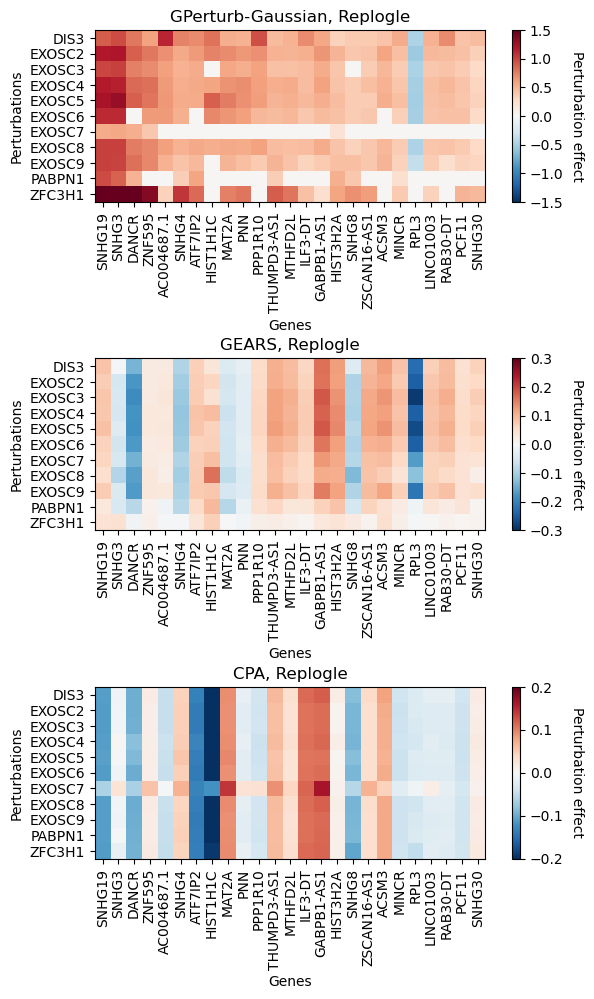

In [13]:
GEARS_pert = pd.read_csv('./GPerturb_vis_data/Rep_GEARS_subset.csv', index_col=0)
GPerturb_pert = pd.read_csv('./GPerturb_vis_data/Rep_GPerturb_Gaussian_subset.csv', index_col=0)
CPA_pert = pd.read_csv('./GPerturb_vis_data/CPA_Rep_isolated_pert.csv', index_col=0)

import matplotlib.colors as colors

fig2, axes2 = plt.subplots(3, 1)
negatives = -1.5
positives = 1.5 
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2[0].imshow(GPerturb_pert, cmap=cmap_2neg_4pos, vmin=negatives, vmax=positives)
axes2[0].set_xticks(np.arange(len(GPerturb_pert.columns)), GPerturb_pert.columns, rotation=90)
axes2[0].set_yticks(np.arange(len(GPerturb_pert.index)), GPerturb_pert.index)
axes2[0].set_ylabel('')
axes2[0].set_xlabel('Genes')
axes2[0].set_ylabel('Perturbations')
axes2[0].set_title('GPerturb-Gaussian, Replogle')
axes2[0].set_aspect('equal')
cbar = fig2.colorbar(im, ax=axes2[0], fraction=0.04)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Perturbation effect', rotation=270)


negatives = -0.3 
positives = 0.3 
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2[1].imshow(GEARS_pert, cmap=cmap_2neg_4pos, vmin=negatives, vmax=positives)
axes2[1].set_xticks(np.arange(len(GEARS_pert.columns)), GEARS_pert.columns, rotation=90)
axes2[1].set_yticks(np.arange(len(GEARS_pert.index)), GEARS_pert.index)
# axes2.set_xticks([])
# axes2.set_yticks([])
axes2[1].set_ylabel('')
axes2[1].set_xlabel('Genes')
axes2[1].set_ylabel('Perturbations')
axes2[1].set_title('GEARS, Replogle')
axes2[1].set_aspect('equal')
cbar = fig2.colorbar(im, ax=axes2[1], fraction=0.04)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Perturbation effect', rotation=270)


negatives = -0.2 
positives = 0.2 
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2[2].imshow(CPA_pert, cmap=cmap_2neg_4pos, vmin=negatives, vmax=positives)
axes2[2].set_xticks(np.arange(len(CPA_pert.columns)), CPA_pert.columns, rotation=90)
axes2[2].set_yticks(np.arange(len(CPA_pert.index)), CPA_pert.index)
# axes2.set_xticks([])
# axes2.set_yticks([])
axes2[2].set_ylabel('')
axes2[2].set_xlabel('Genes')
axes2[2].set_ylabel('Perturbations')
axes2[2].set_title('CPA, Replogle')
axes2[2].set_aspect('equal')
cbar = fig2.colorbar(im, ax=axes2[2], fraction=0.04)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Perturbation effect', rotation=270)

fig2.set_size_inches(7, 10)
fig2.tight_layout()
plt.savefig('fig-rep-heatmaps-a.png', dpi=200)

# Fig 3b

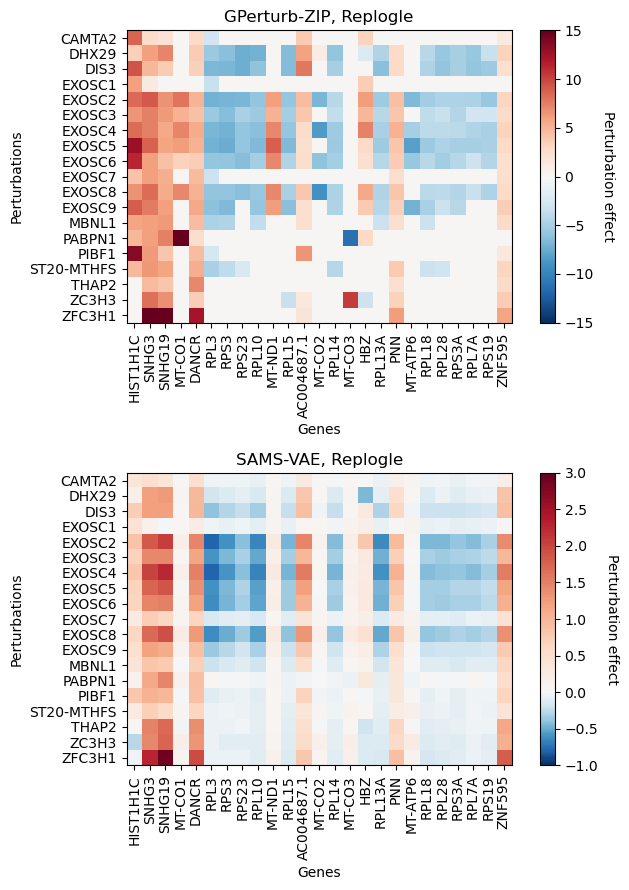

In [14]:
SAMS_pert = pd.read_csv('./GPerturb_vis_data/Rep_SAMS_subset.csv', index_col=0)
GPerturb_pert = pd.read_csv('./GPerturb_vis_data/Rep_ZIP_subset.csv', index_col=0)

import matplotlib.colors as colors

fig2, axes2 = plt.subplots(2, 1)
negatives = -15 
positives = 15 
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2[0].imshow(GPerturb_pert, cmap=cmap_2neg_4pos, vmin=negatives, vmax=positives)
axes2[0].set_xticks(np.arange(len(GPerturb_pert.columns)), GPerturb_pert.columns, rotation=90)
axes2[0].set_yticks(np.arange(len(GPerturb_pert.index)), GPerturb_pert.index)
axes2[0].set_ylabel('')
axes2[0].set_xlabel('Genes')
axes2[0].set_ylabel('Perturbations')
axes2[0].set_title('GPerturb-ZIP, Replogle')
axes2[0].set_aspect('equal')
cbar = fig2.colorbar(im, ax=axes2[0], fraction=0.04)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Perturbation effect', rotation=270)


negatives = -1 
positives = 3 
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2[1].imshow(SAMS_pert, cmap=cmap_2neg_4pos, vmin=negatives, vmax=positives)
axes2[1].set_xticks(np.arange(len(SAMS_pert.columns)), SAMS_pert.columns, rotation=90)
axes2[1].set_yticks(np.arange(len(SAMS_pert.index)), SAMS_pert.index)
# axes2.set_xticks([])
# axes2.set_yticks([])
axes2[1].set_ylabel('')
axes2[1].set_xlabel('Genes')
axes2[1].set_ylabel('Perturbations')
axes2[1].set_title('SAMS-VAE, Replogle')
axes2[1].set_aspect('equal')
cbar = fig2.colorbar(im, ax=axes2[1], fraction=0.04)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Perturbation effect', rotation=270)


fig2.set_size_inches(7, 9)
fig2.tight_layout()
plt.savefig('fig-rep-heatmaps-b.png', dpi=200)

# Fig 4a

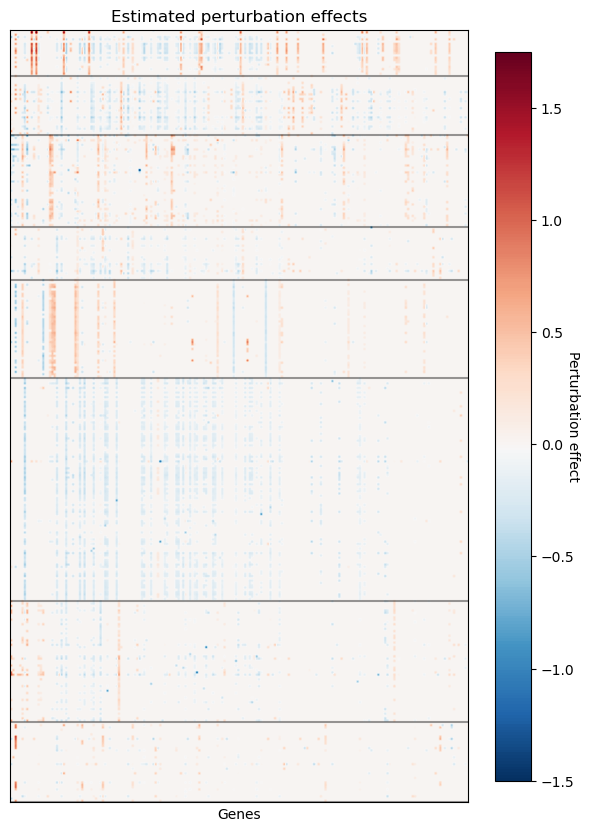

In [43]:
adata = sc.read_h5ad('./data/Replogle_et_el/replogle.h5ad')
pathways = adata.uns['pathways']

estimated_pert_rep = pd.read_csv('./GPerturb_vis_data/Rep_Gaussian_estimated_pert.csv').to_numpy()
import matplotlib.colors as colors
fig2, axes2 = plt.subplots(1, 1)
negatives = -1.5
positives = 1.8 
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2.imshow(estimated_pert_rep, cmap=cmap_2neg_4pos, vmin=-1.5, vmax=1.75)
axes2.set_xticks([])
axes2.set_yticks([])
axes2.set_ylabel('')
for l in np.cumsum([len(i) for i in pathways.values()]):
    axes2.axline((0., l-0.5), slope=0, alpha=0.4, c='k')
axes2.set_xlabel('Genes')
axes2.set_title('Estimated perturbation effects')
axes2.set_aspect('equal')
cbar = fig2.colorbar(im, ax=axes2, fraction=0.07)
cbar.ax.set_ylabel('Perturbation effect', rotation=270)
fig2.set_size_inches(6, 9)
fig2.tight_layout()
plt.savefig('fig-perturb-effects-a.png', dpi=200)

# Fig 4b

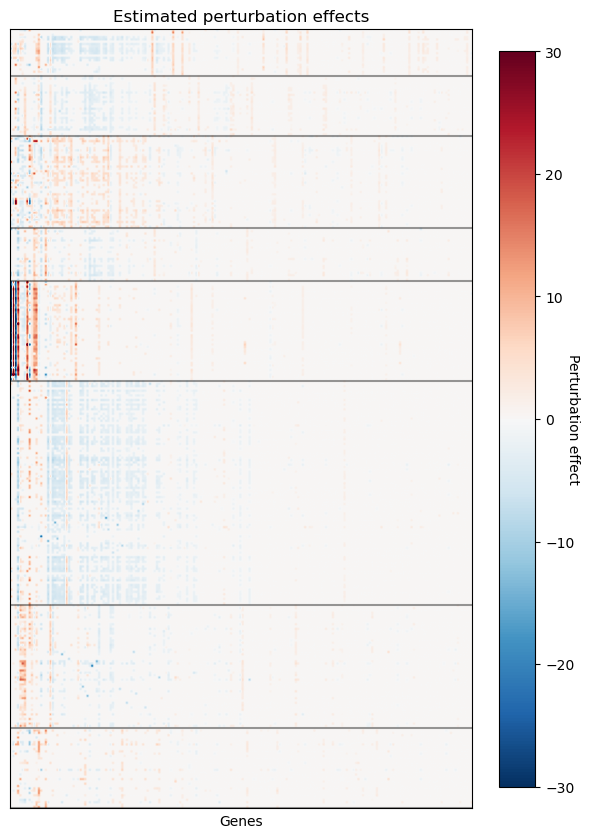

In [17]:
adata = sc.read_h5ad('./data/Replogle_et_el/replogle.h5ad')
pathways = adata.uns['pathways']

estimated_pert_rep = pd.read_csv('./GPerturb_vis_data/perturb_level_Rep.csv').to_numpy()
import matplotlib.colors as colors
fig2, axes2 = plt.subplots(1, 1)
negatives = -30 # estimated_pert_reo.min()
positives = 30 #  estimated_pert_reo.max()
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2.imshow(estimated_pert_rep, cmap=cmap_2neg_4pos, vmin=-30, vmax=30)
axes2.set_xticks([])
axes2.set_yticks([])
axes2.set_ylabel('')
for l in np.cumsum([len(i) for i in pathways.values()]):
    axes2.axline((0., l-0.5), slope=0, alpha=0.4, c='k')
axes2.set_xlabel('Genes')
axes2.set_title('Estimated perturbation effects')
axes2.set_aspect('equal')
cbar = fig2.colorbar(im, ax=axes2, fraction=0.07)
cbar.ax.set_ylabel('Perturbation effect', rotation=270)
fig2.set_size_inches(6, 9)
fig2.tight_layout()
plt.savefig('fig-perturb-effects-b.png', dpi=200)

# Fig 5

541.6525595188141


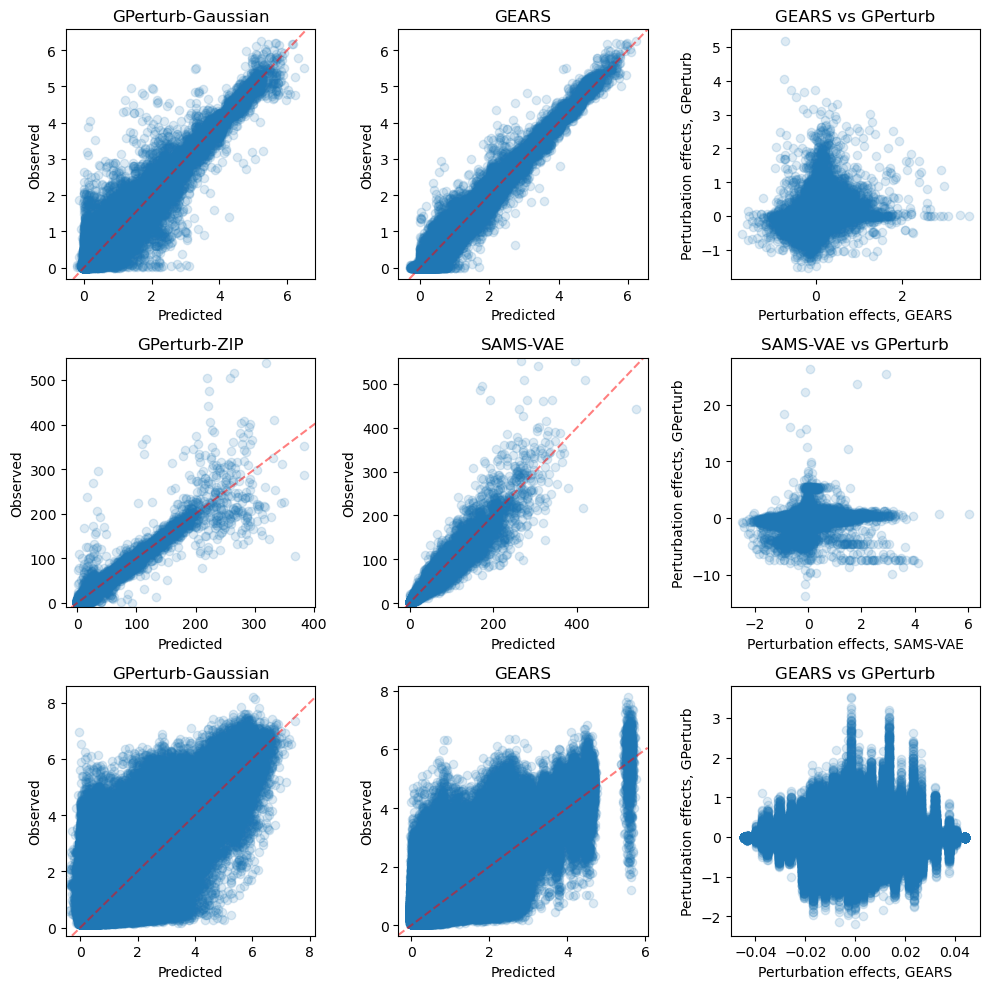

In [47]:
start=time.time()
fig, axes = plt.subplots(3, 3)

# Norman, GPerturb-Gaussian vs GEARS
gears_pred = pd.read_csv('./GPerturb_vis_data/Norman_GEARS_pred.csv', index_col=0)
avg_pred = np.load('./GPerturb_vis_data/GPerturb_Norman.npy')
avg_obs = np.load('./GPerturb_vis_data/avg_obs_Norman.npy')

axes[0, 0].scatter(avg_pred[avg_obs != 0], avg_obs[avg_obs != 0], alpha=0.15)
axes[0, 0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Observed')
axes[0, 0].set_title('GPerturb-Gaussian')

axes[0, 1].scatter(gears_pred.to_numpy().ravel(), avg_obs.ravel(), alpha=0.15)
axes[0, 1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Observed')
axes[0, 1].set_title('GEARS')

a = pd.read_csv('./GPerturb_vis_data/Norman_GEARS_pred_alone.csv', index_col=0)
b = pd.read_csv('./GPerturb_vis_data/Norman_Gaussian_pred_alone.csv', index_col=0)

# align the genes_id and perturbation_ids
intersection_pert = sorted(list(set(a.index).intersection(b.index)))
a = a.loc[intersection_pert]
b = b.loc[intersection_pert]
b = b[~b.index.duplicated(keep='first')]
intersection_col = sorted(list(set(a.columns).intersection(b.columns)))
a = a[intersection_col]
b = b[intersection_col]

axes[0, 2].scatter(a.to_numpy().ravel(), b.to_numpy().ravel(), alpha=0.15)
axes[0, 2].set_xlabel('Perturbation effects, GEARS')
axes[0, 2].set_ylabel('Perturbation effects, GPerturb')
axes[0, 2].set_title('GEARS vs GPerturb')



# Norman, GPerturb-ZIP vs SAMS-VAE
avg_pred = np.loadtxt('./GPerturb_vis_data/norman_avg_pred_GPerturb_zip.csv').ravel()
avg_obs = np.loadtxt('./GPerturb_vis_data/norman_avg_obs_GPerturb_zip.csv').ravel()
avg_pred = avg_pred[avg_obs != 0]
avg_obs = avg_obs[avg_obs != 0]
axes[1, 0].scatter(avg_pred, avg_obs, alpha=0.15)
axes[1, 0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Observed')
axes[1, 0].set_title('GPerturb-ZIP')
axes[1, 0].set_ylim(-10, 550)

avg_pred = pd.read_csv('./GPerturb_vis_data/Norman_SAMS_VAE_pred.csv', index_col=0).to_numpy().ravel()
avg_obs = pd.read_csv('./GPerturb_vis_data/Norman_SAMS_VAE_obs.csv', index_col=0).to_numpy().ravel()
avg_pred = avg_pred[avg_obs != 0]
avg_obs = avg_obs[avg_obs != 0]
axes[1, 1].scatter(avg_pred, avg_obs, alpha=0.15)
axes[1, 1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Observed')
axes[1, 1].set_title('SAMS-VAE')
axes[1, 1].set_ylim(-10, 560)


a = pd.read_csv('./GPerturb_vis_data/Norman_SAMS_VAE_treatment_effects.csv', index_col=0)
b = pd.read_csv('./GPerturb_vis_data/Norman_GPerturb_ZIP_pred_alone.csv', index_col=0)

# align the genes_id and perturbation_ids
intersection_pert = sorted(list(set(a.index).intersection(b.index)))
a = a.loc[intersection_pert]
b = b.loc[intersection_pert]
b = b[~b.index.duplicated(keep='first')]
intersection_col = sorted(list(set(a.columns).intersection(b.columns)))
a = a[intersection_col]
b = b[intersection_col]

axes[1, 2].scatter(a.to_numpy().ravel(), b.to_numpy().ravel(), alpha=0.15)
axes[1, 2].set_xlabel('Perturbation effects, SAMS-VAE')
axes[1, 2].set_ylabel('Perturbation effects, GPerturb')
axes[1, 2].set_title('SAMS-VAE vs GPerturb')


# Yao et al, GEARS vs GPerturb-Gaussian
avg_pred = np.loadtxt('./GPerturb_vis_data/yao_pred_GPerturb.csv').ravel()
avg_obs = np.loadtxt('./GPerturb_vis_data/yao_obs_GPerturb.csv').ravel()
avg_pred = avg_pred[avg_obs != 0]
avg_obs = avg_obs[avg_obs != 0]
axes[2, 0].scatter(avg_pred,  avg_obs, alpha=0.15)
axes[2, 0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[2, 0].set_xlim(-0.5, 8.2)
axes[2, 0].set_xlabel('Predicted')
axes[2, 0].set_ylabel('Observed')
axes[2, 0].set_title('GPerturb-Gaussian')

obs_mean = np.load('./GPerturb_vis_data/yao_GEARS_avg_1.npy').ravel()
pert_response = pd.read_csv('./GPerturb_vis_data/yao_GEARS_pred_1.csv', index_col=0).to_numpy().ravel()
pert_response = pert_response[obs_mean != 0]
obs_mean = obs_mean[obs_mean != 0]
axes[2, 1].scatter(pert_response.ravel()[obs_mean.ravel() != 0], obs_mean.ravel()[obs_mean.ravel() != 0], alpha=0.15)
axes[2, 1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[2, 1].set_xlabel('Predicted')
axes[2, 1].set_ylabel('Observed')
axes[2, 1].set_title('GEARS')


a = pd.read_csv('./GPerturb_vis_data/yao_GEARS_pred_alone.csv', index_col=0)
b = np.loadtxt('./GPerturb_vis_data/yao_GPerturb_alone.csv')
axes[2, 2].scatter(a.to_numpy().ravel(), b.ravel(), alpha=0.15)
axes[2, 2].set_xlabel('Perturbation effects, GEARS')
axes[2, 2].set_ylabel('Perturbation effects, GPerturb')
axes[2, 2].set_title('GEARS vs GPerturb')
axes[2, 2].set_xlim(-0.05, 0.05)
fig.set_size_inches(10, 10)
fig.tight_layout()
plt.savefig('fig-norman.png', dpi=200)
print(time.time()-start)

# Fig 6

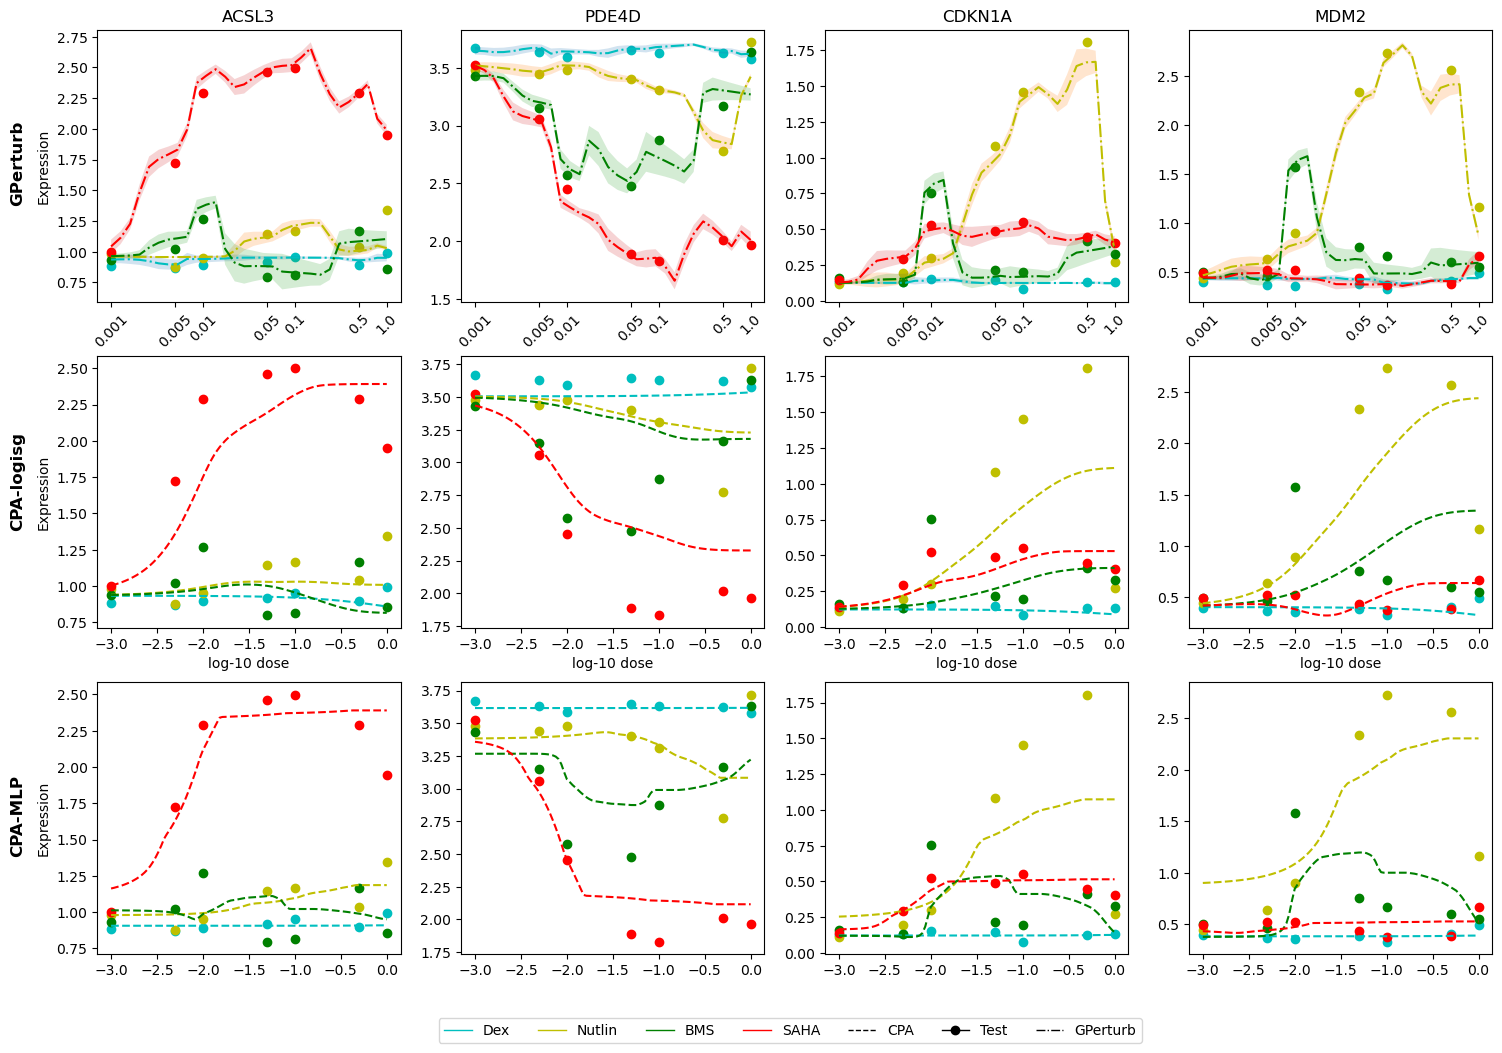

In [35]:
BSAPR_avg_pred = pd.read_csv('./GPerturb_vis_data/Sciplex2_BSAPR_avg_pred.csv', index_col=0)
obs_avg = pd.read_csv('./GPerturb_vis_data/Sciplex2_obs_avg.csv', index_col=0)
CPA_avg_pred_MLP = pd.read_csv('./GPerturb_vis_data/CPA_avg_pred_MLP.csv', index_col=0)
CPA_avg_pred = pd.read_csv('./GPerturb_vis_data/Sciplex2_CPA_avg_pred.csv', index_col=0)

degs = ['ACSL3', 'PDE4D', 'CDKN1A','MDM2']
f, a = plt.subplots(nrows=3, ncols=4)
for i in range(12):
    my_id = i%4
    my_data_CPA = CPA_avg_pred[CPA_avg_pred.gene==degs[my_id]]
    my_data_CPA_MLP = CPA_avg_pred_MLP[CPA_avg_pred.gene == degs[my_id]]
    my_data_obs = obs_avg[obs_avg.gene == degs[my_id]]
    my_data_BSAPR = BSAPR_avg_pred[BSAPR_avg_pred.gene == degs[my_id]]
    lty = ['--', '-', '-.']
    col = ['c', 'y', 'g', 'r']
    for idx, j in enumerate(['Dex', 'Nutlin', 'BMS', 'SAHA']):
        if i//4 == 2:
            a[i // 4, i%4].plot(np.linspace(-3, 0, 100), np.array(my_data_CPA_MLP[my_data_CPA_MLP.pert == j].sort_values(by='dose').CPA), linestyle=lty[0], label=j, c=col[idx])
            a[i // 4, i % 4].scatter(np.log10([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]),
            np.array(my_data_obs[my_data_obs.pert == j].sort_values(by='dose').obs),
            marker='o', c=col[idx])
        elif i//4 == 1:
            a[i // 4, i%4].plot(np.linspace(-3, 0, 100), np.array(my_data_CPA[my_data_CPA.pert == j].sort_values(by='dose').CPA), linestyle=lty[0], label=j, c=col[idx])
            a[i // 4, i % 4].scatter(np.log10([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]),
            np.array(my_data_obs[my_data_obs.pert == j].sort_values(by='dose').obs),
            marker='o', c=col[idx])
        else:
            a[i // 4, i % 4].scatter(np.log10([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]), np.array(my_data_obs[my_data_obs.pert == j].sort_values(by='dose').obs), marker='o', c=col[idx])
            a[i // 4, i % 4].plot(np.linspace(-3, 0, 30),
            np.array(my_data_BSAPR[my_data_BSAPR.pert == j].sort_values(by='dose').BSAPR), linestyle=lty[2], c=col[idx])
            a[i // 4, i % 4].fill_between(np.linspace(-3, 0, 30),
            np.array(my_data_BSAPR[my_data_BSAPR.pert == j].sort_values(by='dose').BSAPR_lower),
            np.array(my_data_BSAPR[my_data_BSAPR.pert == j].sort_values(by='dose').BSAPR_upper), alpha=0.2)
            a[i // 4, i % 4].set_title(degs[i])
            
            a[i // 4, i % 4].set_xticks(ticks=np.log10([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]), labels=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0], rotation=45)
    if i//4 == 1:
        a[i // 4, i % 4].set_xlabel('log-10 dose')
    else:
        a[i // 4, i % 4].set_xlabel('')
    if i%4 == 0:
        a[i // 4, i % 4].set_ylabel('Expression')
a[0, 0].text(-4.1, 1.40, 'GPerturb', rotation='vertical', fontsize=12, weight='demibold')
a[1, 0].text(-4.1, 1.40, 'CPA-logisg', rotation='vertical', fontsize=12, weight='demibold')
a[2, 0].text(-4.1, 1.40, 'CPA-MLP', rotation='vertical', fontsize=12, weight='demibold')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='c', lw=1, label='Dex'),
    Line2D([0], [0], color='y', lw=1, label='Nutlin'),
    Line2D([0], [0], color='g', lw=1, label='BMS'),
    Line2D([0], [0], color='r', lw=1, label='SAHA'),
    Line2D([0], [0], color='k', lw=1, linestyle='--', label='CPA'),
    Line2D([0], [0], color='k', lw=1, marker='o', label='Test'),
    Line2D([0], [0], color='k', lw=1, linestyle='-.', label='GPerturb')]

f.legend(handles=legend_elements, loc='lower center', ncol=7, bbox_to_anchor=(.51, 0.03))
f.set_size_inches(18, 12)
plt.savefig('fig-cpa.png', dpi=200)

# Fig 7 

457.79180932044983


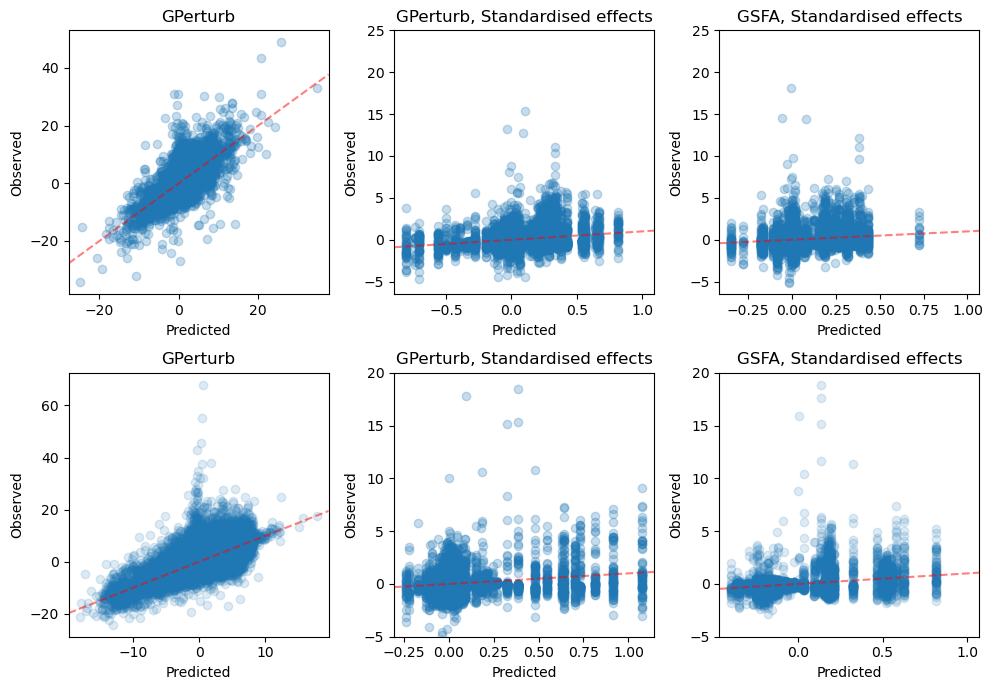

In [33]:
# (slow on jupyer notebook)
start=time.time()
# load pre-computed estimates
pert_mean_LUHMES = pd.read_csv('./GPerturb_vis_data/pert_mean_LUHMES.csv').to_numpy().ravel()
obs_LUHMES = pd.read_csv('./GPerturb_vis_data/obs_LUHMES.csv').to_numpy().ravel()
normed_pert_effect_LUHMES = pd.read_csv('./GPerturb_vis_data/normed_pert_effect_LUHMES.csv').to_numpy().ravel()
normed_pert_removed_LUHMES = pd.read_csv('./GPerturb_vis_data/normed_pert_removed_LUHMES.csv').to_numpy().ravel()

# load outcomes generated by GSFA
GSFA_fit_LUHMES = pd.read_csv('./GPerturb_vis_data/GSFA_fit_LUHMES.csv').to_numpy().ravel()
GSFA_obs_LUHMES = pd.read_csv('./GPerturb_vis_data/GSFA_obs_LUHMES.csv').to_numpy().ravel()

fig, axes = plt.subplots(2,3)  

# LUHMES
axes[0, 0].scatter(pert_mean_LUHMES, obs_LUHMES, alpha=0.25)
axes[0, 0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Observed')
axes[0, 0].set_title('GPerturb')

axes[0, 1].scatter(normed_pert_effect_LUHMES,
                   normed_pert_removed_LUHMES, alpha=0.25)
axes[0, 1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0, 1].set_ylim(-6.5, 25)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Observed')
axes[0, 1].set_title('GPerturb, Standardised effects')

axes[0, 2].scatter(GSFA_fit_LUHMES, GSFA_obs_LUHMES, alpha=0.25)
axes[0, 2].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0, 2].set_ylim(-6.5, 25)
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Observed')
axes[0, 2].set_title('GSFA, Standardised effects')

#TCells
# load from pre-computed
pert_mean_TCells = pd.read_csv('pert_mean_TCells.csv').to_numpy().ravel()
obs_TCells = pd.read_csv('obs_TCells.csv').to_numpy().ravel()
normed_pert_effect_TCells = pd.read_csv('normed_pert_effect_TCells.csv').to_numpy().ravel()
normed_pert_removed_TCells = pd.read_csv('normed_pert_removed_TCells.csv').to_numpy().ravel()
GSFA_fit_TCells = pd.read_csv('GSFA_fit_TCells.csv').to_numpy().ravel()
GSFA_obs_TCells = pd.read_csv('GSFA_obs_TCells.csv').to_numpy().ravel()

GSFA_fit_TCells = pd.read_csv('GSFA_fit_TCells.csv').to_numpy().ravel()
GSFA_obs_TCells = pd.read_csv('GSFA_obs_TCells.csv').to_numpy().ravel()

axes[1, 0].scatter(pert_mean_TCells, obs_TCells, alpha=0.15)
axes[1, 0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Observed')
axes[1, 0].set_title('GPerturb')

axes[1, 1].scatter(normed_pert_effect_TCells,
                   normed_pert_removed_TCells,
                            alpha=0.25)
axes[1, 1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1, 1].set_ylim(-5, 20)
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Observed')
axes[1, 1].set_title('GPerturb, Standardised effects')


axes[1, 2].scatter(GSFA_fit_TCells, GSFA_obs_TCells, alpha=0.15)
axes[1, 2].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1, 2].set_ylim(-5, 20)
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Observed')
axes[1, 2].set_title('GSFA, Standardised effects')

fig.set_size_inches(10, 7)
fig.tight_layout()
plt.savefig('fig-gsfa.png', dpi=250)
print(time.time()-start)